# STL 分解時間序列資料的方法

本教學將展示如何在時間序列資料上執行 STL（季節性與趨勢分解，使用 Loess）分解。

STL 分解是一種強大的工具，可用於理解時間序列中的基礎組成，包括季節性模式、趨勢與殘差。

我們將進行：

- 匯入所需程式庫
- 載入並探索 AirPassengers 資料集
- 執行 STL 分解
- 視覺化並解讀季節性、趨勢與殘差組成
- 辨識高、低季

**參考資料：**

- [statsmodels STL 文件](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.STL.html)
- [AirPassengers 資料集](https://vincentarelbundock.github.io/Rdatasets/articles/data.html)

---

## 1. 匯入所需程式庫

我們將匯入 Pandas、matplotlib 及 statsmodels 程式庫，分別用於資料處理、視覺化與 STL 分解。

In [1]:
# 匯入所需程式庫
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm

## 2. 載入並探索資料集

我們將使用 `AirPassengers` 資料集，內容為 1949 至 1960 年每月國際航空旅客總數。

資料集將載入並將時間欄設為索引。先顯示前幾列以了解其結構。

In [2]:
# 載入 AirPassengers 資料集
# https://vincentarelbundock.github.io/Rdatasets/articles/data.html
data = sm.datasets.get_rdataset("AirPassengers", "datasets").data

# 新增時間欄並設為索引
data['time'] = pd.date_range(
  start='1949-01',    # 起始時間
  periods=len(data),  # 資料點數
  freq='ME'           # 月末頻率
)
data.set_index('time', inplace=True)

# 顯示前 20 筆資料
data.head(20)

,value
time,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121
1949-06-30,135
1949-07-31,148
1949-08-31,148
1949-09-30,136


讓我們先將這些資料點視覺化，方便理解時間序列的行為。

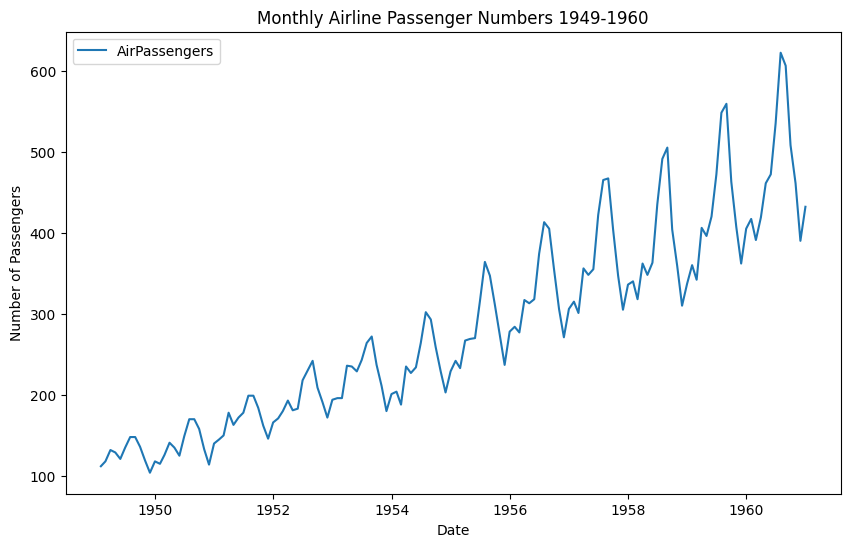

In [3]:
# 繪製時間序列圖
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['value'], label='AirPassengers')
plt.title('Monthly Airline Passenger Numbers 1949-1960')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

---

## 3. 執行 STL 分解

我們將使用 statsmodels 的 STL 類別將時間序列分解為三個組成：
- **季節性 (Seasonal)**：捕捉資料中的重複模式或週期。
- **趨勢 (Trend)**：反映序列的長期變化。
- **殘差 (Residual)**：移除季節性與趨勢後剩餘的變異。

In [4]:
# 執行 STL 分解
stl = STL(
  data['value'],
  seasonal=13  # 每月資料有年度季節性，選擇接近 12 的奇數 13
)
result = stl.fit()

STL 分解中的 `seasonal=13` 參數指定資料的季節週期長度。以下說明為何在本例使用 13，以及如何在其他情境下決定此參數：

### **為何 AirPassengers 使用 `seasonal=13`？**
1. **每月資料**：AirPassengers 資料集為每月資料。
2. **年度季節性**：資料呈現明顯年度季節循環，即每 12 個月重複一次。
3. **奇數視窗長度**：STL 需要季節平滑視窗為奇數。12 為偶數，因此選用最接近的奇數 13 以捕捉年度季節性。

### **如何決定其他情境的 seasonal 參數**
1. **了解資料頻率**：
   - 若資料為每日，考慮是否有每週、每月或每年週期。
   - 若資料為每小時，考慮每日或每週週期。
   - 若資料為每月，則多為年度週期。
2. **辨識季節週期**：
   - 觀察資料重複模式，例如：
     - 每日資料有每週週期 → `seasonal=7`。
     - 每月資料有年度週期 → `seasonal=13`（或最接近 12 的奇數）。
   - 可用領域知識 (Domain knowledge) 或資料視覺化協助判斷。
3. **選擇奇數**：
   - STL 需要季節平滑視窗為奇數，若週期長度為偶數，選擇最接近的奇數。
4. **實驗與驗證**：
   - 若不確定，可嘗試不同 `seasonal` 參數並評估分解結果，觀察季節性與趨勢是否平滑且殘差噪音最小。

### **seasonal 範例參數**
- **每日資料有每週季節性**：用 `seasonal=7`。
- **每小時資料有每日季節性**：用 `seasonal=25`（接近 24 小時）。
- **每季資料有年度季節性**：用 `seasonal=5`（接近 4 季）。

理解資料頻率與週期後，即可決定 STL 分解的 `seasonal` 參數。

---

## 4. 季節性組成 (Seasonal Component)

季節性組成揭示資料中的重複模式，例如每月或每年循環。以 `AirPassengers` 資料為例，可觀察到明顯的年度季節性，高峰與低谷分別對應特定月份。

以下將擷取並視覺化季節性組成。

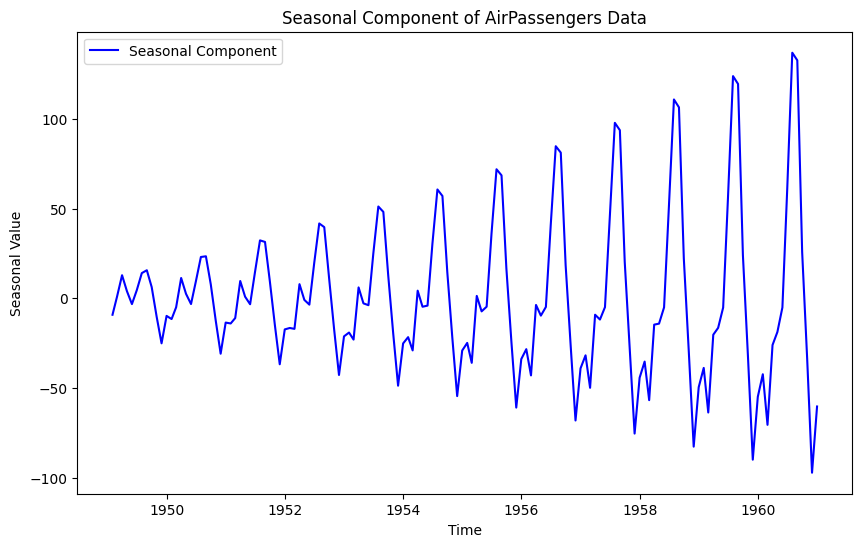

In [5]:
# 擷取並視覺化季節性組成
plt.figure(figsize=(10, 6))
plt.plot(
  result.seasonal, # 季節性組成
  label='Seasonal Component',
  color='blue'
)

plt.title('Seasonal Component of AirPassengers Data')
plt.xlabel('Time')
plt.ylabel('Seasonal Value')
plt.legend()
plt.show()

### 高／低季

以 STL 的季節性組成判別高、低季：
- 高峰 → 高季；低谷 → 低季。
- 使用 `seasonal.idxmax()` / `seasonal.idxmin()` 取得對應時點。
- 視覺化季節性曲線並加標註線或表格標示。

In [6]:
# 擷取季節性組成
seasonal = result.seasonal

# 找出季節性最高與最低的月份
high_season = seasonal.idxmax()
low_season = seasonal.idxmin()

print(f"High season occurs in: {high_season}")
print(f"Low season occurs in: {low_season}")

High season occurs in: 1960-07-31 00:00:00
Low season occurs in: 1960-11-30 00:00:00


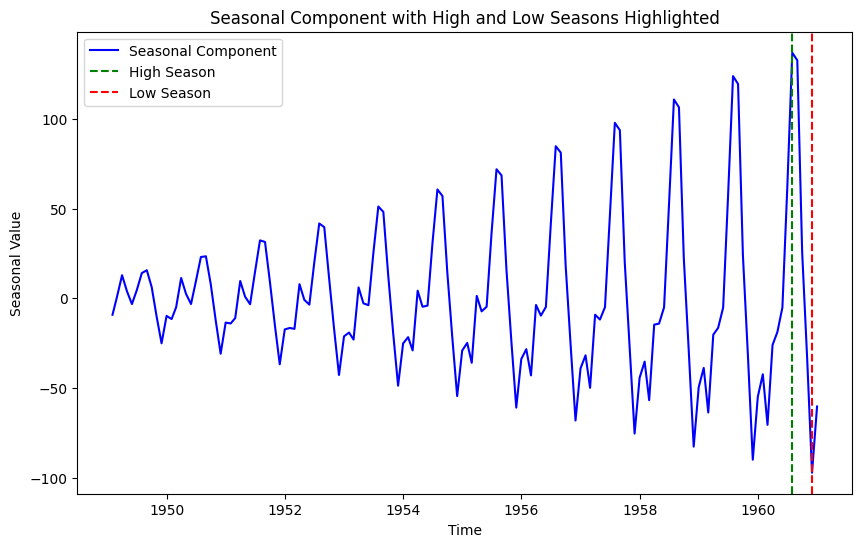

In [7]:
# 視覺化季節性組成並標註高、低季
plt.figure(figsize=(10, 6))
plt.plot(
  seasonal,
  label='Seasonal Component',
  color='blue')
# 標註高、低季
plt.axvline(
  high_season,
  color='green',
  linestyle='--',
  label='High Season'
)
plt.axvline(
  low_season,
  color='red',
  linestyle='--',
  label='Low Season'
)

plt.title('Seasonal Component with High and Low Seasons Highlighted')
plt.xlabel('Time')
plt.ylabel('Seasonal Value')
plt.legend()
plt.show()

---

## 5. 趨勢組成 (Trend Component)

趨勢組成顯示旅客人數隨時間穩定成長，反映觀察期間國際航空旅運的成長趨勢。

以下將擷取並視覺化趨勢組成。

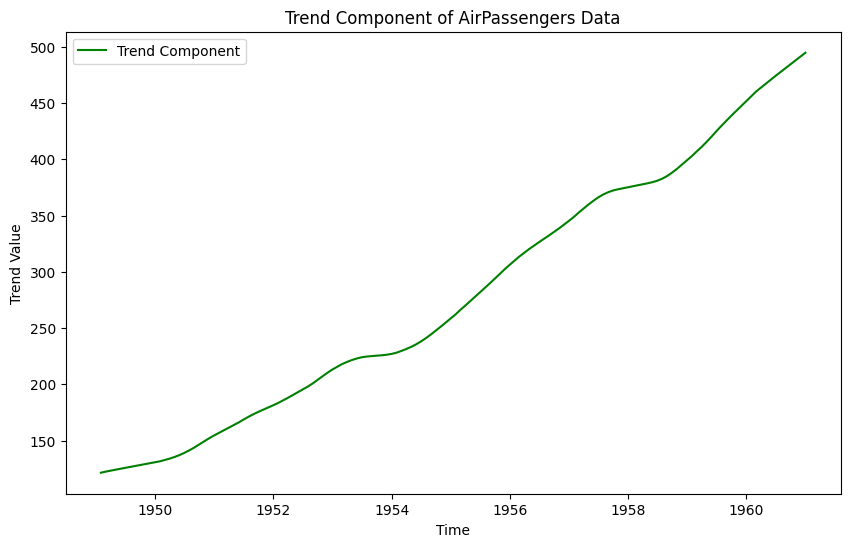

In [8]:
# 擷取並視覺化趨勢組成
plt.figure(figsize=(10, 6))
plt.plot(
  result.trend, # 趨勢組成
  label='Trend Component',
  color='green'
)

plt.title('Trend Component of AirPassengers Data')
plt.xlabel('Time')
plt.ylabel('Trend Value')
plt.legend()
plt.show()

---

## 6. 殘差組成 (Residual Component)

殘差組成代表移除季節性與趨勢後，資料剩餘的變異。

殘差組成捕捉資料中的隨機雜訊或未解釋的變異。分析殘差有助於辨識異常或不規則現象。

以下將擷取並視覺化殘差組成。

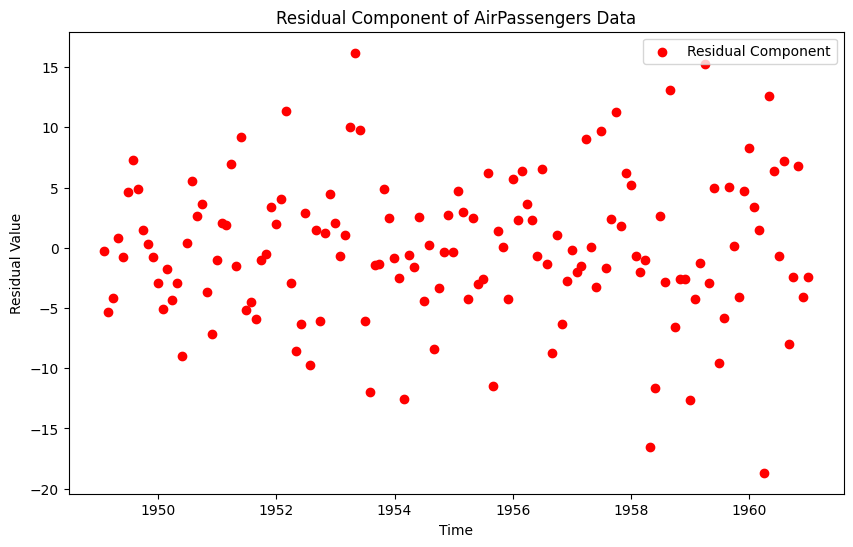

In [9]:
# 擷取並視覺化殘差組成
plt.figure(figsize=(10, 6))
plt.scatter(
  result.resid.index, # 時間索引
  result.resid, # 殘差組成
  label='Residual Component',
  color='red'
)

plt.title('Residual Component of AirPassengers Data')
plt.xlabel('Time')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

---

## 7. 分解結果視覺化

雖然可以分別視覺化各組成，但為了方便起見，STL 提供內建方法可同時視覺化所有組成（季節性、趨勢、殘差）。

以下使用此方法快速總覽分解結果。

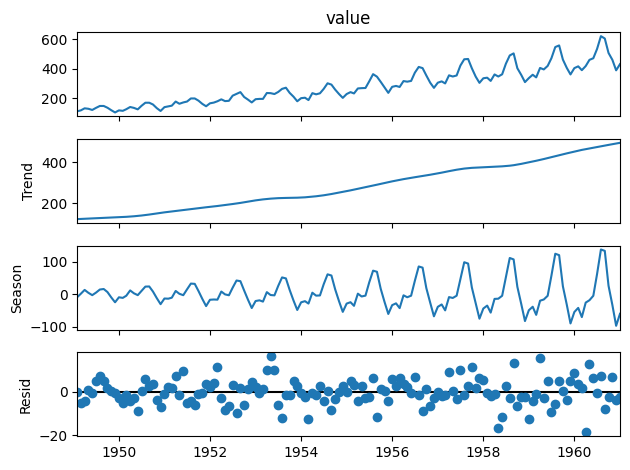

In [10]:
# 同時視覺化所有組成
result.plot()
plt.show()

---

## 8. STL 分解在異常偵測中的應用

STL 分解不僅能協助理解時間序列的結構，也常被用於異常偵測。

其核心概念是：將原始序列分解為趨勢、季節性與殘差，然後分析殘差部分以辨識異常。

### 常見異常偵測流程
1. **分解時間序列**：使用 STL 將序列分解為趨勢、季節性與殘差。
2. **分析殘差**：殘差代表移除趨勢與季節性後的剩餘變異，通常包含異常。
3. **設定異常門檻**：可用統計方法（如 Z-score、IQR）判斷殘差是否異常。
4. **標註異常點**：將超過門檻的殘差視為潛在異常。

### 實務建議
- STL 適合有明顯季節性或趨勢的資料。
- 異常偵測前，建議先視覺化殘差，確認分解效果。
- 門檻設定可依資料分布調整，避免誤判。
- 可結合其他方法（如 Isolation Forest、Autoencoder）提升偵測準確度。

以下範例展示如何以 STL 殘差進行異常偵測。

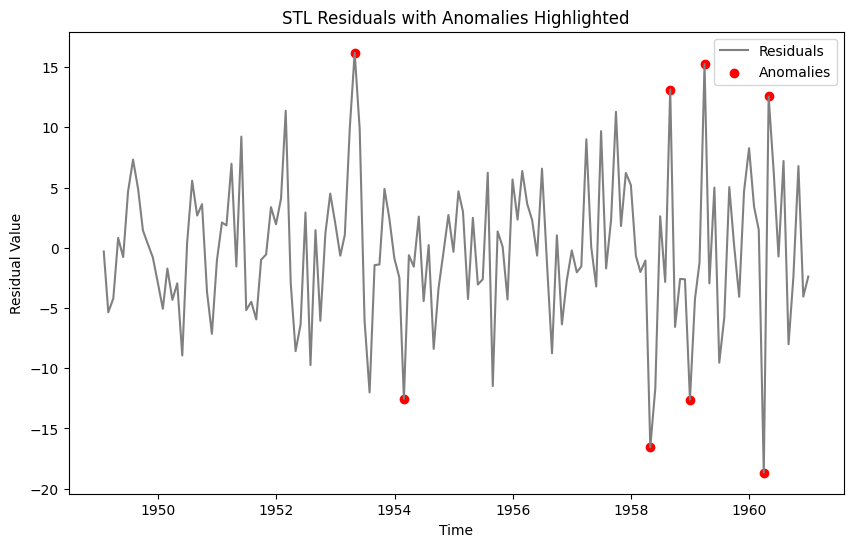

Anomaly timestamps:
DatetimeIndex(['1953-04-30', '1954-02-28', '1958-04-30', '1958-08-31',
               '1958-12-31', '1959-03-31', '1960-03-31', '1960-04-30'],
              dtype='datetime64[ns]', name='time', freq=None)


In [11]:
# 以 STL 殘差進行異常偵測
import numpy as np

# 計算殘差的 Z-score
residuals = result.resid
z_scores = (residuals - residuals.mean()) / residuals.std()

# 設定異常門檻（例如 |Z| > 2）
anomaly_threshold = 2
anomalies = np.abs(z_scores) > anomaly_threshold

# 標註異常點
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals', color='gray')
plt.scatter(residuals.index[anomalies], residuals[anomalies], color='red', label='Anomalies')
plt.title('STL Residuals with Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

# 顯示異常時點
print('Anomaly timestamps:')
print(residuals.index[anomalies])

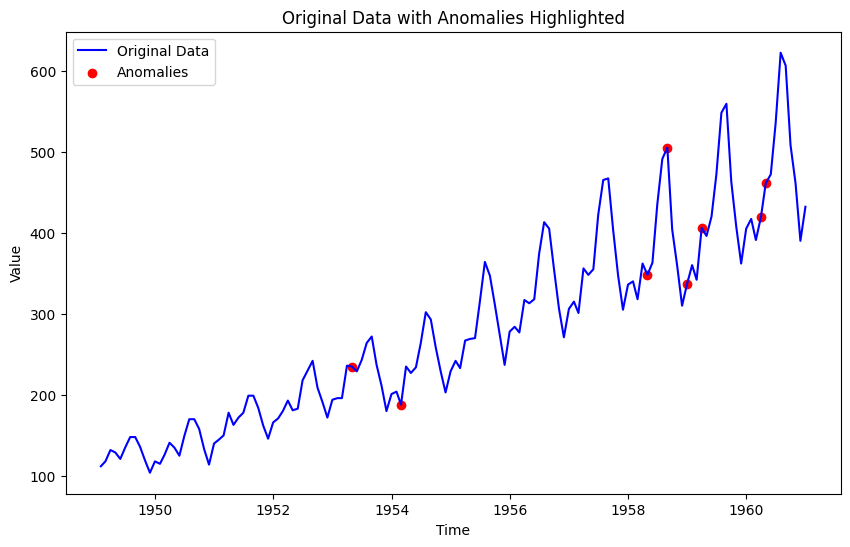

In [12]:
# 將異常點繪製在原始資料上
plt.figure(figsize=(10, 6))
plt.plot(data['value'], label='Original Data', color='blue')
plt.scatter(data.index[anomalies], data['value'][anomalies], color='red', label='Anomalies')
plt.title('Original Data with Anomalies Highlighted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()